In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [6]:
n = 500 * 2
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 1000
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [8]:
x_train.shape

(1000, 160, 7, 1)

In [9]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((1000, 160, 7, 1), 900)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 7)


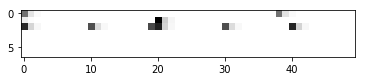

m (50, 7)


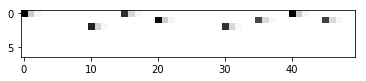

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U125')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [25]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 7, 1)

In [26]:
latent_dim = 20
epsilon_std = 1.0

In [27]:
encoder_model, encoder_input, z_mean, z_log_var = models.encoder(input_shape, latent_dim)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 160, 7)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 159, 64)      960         reshape_3[0][0]                  
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          197632      conv1d_2[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [28]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [29]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [30]:
decoders = models.list_decoders(input_shape)
decoded = utils.composition(decoders, z_output, verbose=False)

In [31]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 20), (None,  208872      input_2[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 20)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          5376        lambda_5[0][0]                   
__________

In [32]:
# vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [33]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 1 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    mse = K.mean(keras.losses.mean_absolute_error(vae_input, vae_output))
    vae_loss = K.mean(xent_loss + beta * kl_loss + 0.2 * mse)
    return vae_loss

vae_loss = vae_loss(beta=1.)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Output "reshape_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_4" during training.
  app.launch_new_instance()


In [34]:
K.int_shape(z_mean)

(None, 20)

In [35]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [36]:
phase_mod = 0.01
whitening = False

In [37]:
m = 1000
useDataGenerator = False
# useDataGenerator = True
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

x = x_train[:m]
# x = x_train
# i = [0,1, 7,8, 14,15, 399,400]
# x = x_train[i]
# x = np.concatenate([x for _ in range(10)])
print('x:', x.shape)

print('batch_size: %i' % batch_size)
print('update-iterations:', round(epochs * x.shape[0] / batch_size))
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
    history = h.history

x: (900, 160, 7, 1)
batch_size: 128
update-iterations: 3516
Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 16s 18ms/step - loss: 395.9154 - val_loss: 83.9916
Epoch 2/500
900/900 [==============================] - 14s 15ms/step - loss: 129.8054 - val_loss: 75.8862
Epoch 3/500
900/900 [==============================] - 14s 16ms/step - loss: 121.0622 - val_loss: 76.6737
Epoch 4/500
900/900 [==============================] - 12s 13ms/step - loss: 119.7286 - val_loss: 75.5922
Epoch 5/500
900/900 [==============================] - 12s 13ms/step - loss: 118.9313 - val_loss: 75.4534
Epoch 6/500
900/900 [==============================] - 16s 18ms/step - loss: 118.1162 - val_loss: 76.6079
Epoch 7/500
900/900 [==============================] - 16s 17ms/step - loss: 117.6918 - val_loss: 76.8142
Epoch 8/500
900/900 [==============================] - 12s 13ms/step - loss: 117.1853 - val_loss: 75.2636
Epoch 9/500
900/900 [=========================

900/900 [==============================] - 11s 12ms/step - loss: 82.1267 - val_loss: 56.8264
Epoch 78/500
900/900 [==============================] - 11s 12ms/step - loss: 82.0190 - val_loss: 57.7563
Epoch 79/500
900/900 [==============================] - 11s 12ms/step - loss: 81.6095 - val_loss: 57.5113
Epoch 80/500
900/900 [==============================] - 11s 13ms/step - loss: 82.2435 - val_loss: 56.4290
Epoch 81/500
900/900 [==============================] - 11s 12ms/step - loss: 82.8340 - val_loss: 58.6004
Epoch 82/500
900/900 [==============================] - 11s 12ms/step - loss: 82.6716 - val_loss: 56.4296
Epoch 83/500
900/900 [==============================] - 11s 12ms/step - loss: 81.7717 - val_loss: 57.0554
Epoch 84/500
900/900 [==============================] - 11s 12ms/step - loss: 81.4176 - val_loss: 57.1523
Epoch 85/500
900/900 [==============================] - 11s 12ms/step - loss: 81.4310 - val_loss: 56.6585
Epoch 86/500
900/900 [==============================] - 11s

Epoch 154/500
900/900 [==============================] - 11s 12ms/step - loss: 77.6004 - val_loss: 55.5202
Epoch 155/500
900/900 [==============================] - 11s 12ms/step - loss: 76.9227 - val_loss: 56.7691
Epoch 156/500
900/900 [==============================] - 11s 12ms/step - loss: 76.5468 - val_loss: 57.2783
Epoch 157/500
900/900 [==============================] - 11s 12ms/step - loss: 76.5656 - val_loss: 57.1455
Epoch 158/500
900/900 [==============================] - 11s 12ms/step - loss: 76.6000 - val_loss: 56.3233
Epoch 159/500
900/900 [==============================] - 11s 12ms/step - loss: 76.5074 - val_loss: 55.9966
Epoch 160/500
900/900 [==============================] - 11s 12ms/step - loss: 76.5895 - val_loss: 56.8686
Epoch 161/500
900/900 [==============================] - 11s 12ms/step - loss: 76.4088 - val_loss: 56.2354
Epoch 162/500
900/900 [==============================] - 11s 12ms/step - loss: 76.2602 - val_loss: 57.2547
Epoch 163/500
900/900 [==============

900/900 [==============================] - 12s 13ms/step - loss: 74.4920 - val_loss: 57.6521
Epoch 231/500
900/900 [==============================] - 12s 13ms/step - loss: 73.7512 - val_loss: 57.9078
Epoch 232/500
900/900 [==============================] - 12s 13ms/step - loss: 73.9673 - val_loss: 57.1657
Epoch 233/500
900/900 [==============================] - 12s 13ms/step - loss: 73.3488 - val_loss: 57.4238
Epoch 234/500
900/900 [==============================] - 12s 13ms/step - loss: 75.7127 - val_loss: 64.3813
Epoch 235/500
900/900 [==============================] - 12s 13ms/step - loss: 85.5944 - val_loss: 60.8636
Epoch 236/500
900/900 [==============================] - 12s 13ms/step - loss: 82.2869 - val_loss: 57.9809
Epoch 237/500
900/900 [==============================] - 12s 13ms/step - loss: 80.2868 - val_loss: 58.3943
Epoch 238/500
900/900 [==============================] - 12s 13ms/step - loss: 79.4585 - val_loss: 57.6458
Epoch 239/500
900/900 [============================

900/900 [==============================] - 12s 13ms/step - loss: 72.5416 - val_loss: 58.8170
Epoch 307/500
900/900 [==============================] - 12s 13ms/step - loss: 72.1174 - val_loss: 59.0840
Epoch 308/500
900/900 [==============================] - 12s 13ms/step - loss: 71.9751 - val_loss: 58.6010
Epoch 309/500
900/900 [==============================] - 12s 13ms/step - loss: 71.9474 - val_loss: 59.2164
Epoch 310/500
900/900 [==============================] - 12s 13ms/step - loss: 71.4608 - val_loss: 60.3383
Epoch 311/500
900/900 [==============================] - 12s 13ms/step - loss: 71.7832 - val_loss: 60.0376
Epoch 312/500
900/900 [==============================] - 14s 16ms/step - loss: 73.7227 - val_loss: 60.6256
Epoch 313/500
900/900 [==============================] - 12s 14ms/step - loss: 72.6604 - val_loss: 60.3505
Epoch 314/500
900/900 [==============================] - 12s 14ms/step - loss: 72.8626 - val_loss: 59.1387
Epoch 315/500
900/900 [============================

900/900 [==============================] - 12s 13ms/step - loss: 69.6378 - val_loss: 61.1534
Epoch 383/500
900/900 [==============================] - 12s 13ms/step - loss: 71.0048 - val_loss: 60.8906
Epoch 384/500
900/900 [==============================] - 12s 13ms/step - loss: 70.1160 - val_loss: 59.0549
Epoch 385/500
900/900 [==============================] - 12s 13ms/step - loss: 69.8387 - val_loss: 59.1230
Epoch 386/500
900/900 [==============================] - 12s 13ms/step - loss: 69.5589 - val_loss: 59.3697
Epoch 387/500
900/900 [==============================] - 12s 13ms/step - loss: 69.6880 - val_loss: 59.7708
Epoch 388/500
900/900 [==============================] - 12s 13ms/step - loss: 69.1682 - val_loss: 61.3233
Epoch 389/500
900/900 [==============================] - 12s 13ms/step - loss: 69.8210 - val_loss: 59.8552
Epoch 390/500
900/900 [==============================] - 12s 13ms/step - loss: 69.1509 - val_loss: 60.4082
Epoch 391/500
900/900 [============================

900/900 [==============================] - 12s 13ms/step - loss: 67.6532 - val_loss: 60.2591
Epoch 459/500
900/900 [==============================] - 12s 13ms/step - loss: 67.0035 - val_loss: 59.3206
Epoch 460/500
900/900 [==============================] - 12s 13ms/step - loss: 66.9432 - val_loss: 60.7020
Epoch 461/500
900/900 [==============================] - 12s 13ms/step - loss: 67.6382 - val_loss: 60.6058
Epoch 462/500
900/900 [==============================] - 12s 13ms/step - loss: 67.7312 - val_loss: 60.0645
Epoch 463/500
900/900 [==============================] - 12s 13ms/step - loss: 67.5091 - val_loss: 59.8415
Epoch 464/500
900/900 [==============================] - 12s 13ms/step - loss: 67.4486 - val_loss: 58.5769
Epoch 465/500
900/900 [==============================] - 12s 13ms/step - loss: 67.4213 - val_loss: 59.6697
Epoch 466/500
900/900 [==============================] - 12s 13ms/step - loss: 66.9123 - val_loss: 60.5434
Epoch 467/500
900/900 [============================

In [107]:
# def save_dict(dn, name, data={'k': ['v']}):
#     # panda df requires data to be NOT of type {key: scalar}
#     # but rather: {'name':['value']}
#     if len(dn) > 0 and not dn[-1] == '/':
#         dn += '/'
#     if not name[-4:] == '.csv':
#         name += '.csv'
#     fn = dn + name
#     df = pandas.DataFrame(data=data)
#     df.to_csv(fn, sep=',', index=False)
#     return fn

In [106]:
# io.save_dict(history)
io.save_dict('../logs/','train_loss', history)

'../logs/train_loss.csv'

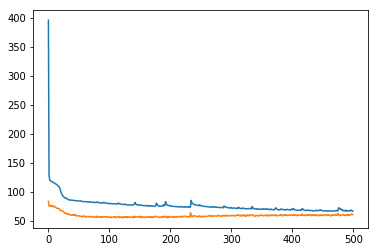

In [38]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

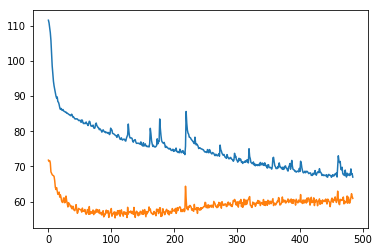

In [39]:
start = 15
plt.plot(history['loss'][start:])
plt.plot(history['val_loss'][start:])

In [40]:
fn = config.model_dir + 'hi_res2b_vae.h5'

In [41]:
# for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
#     model.save_weights(dn + prefix + suffix + '.h5', "w")
vae.save_weights(fn, "w")

In [42]:
# vae.load_weights(fn)

In [43]:
# vae2 = vae

In [44]:
x.shape

(900, 160, 7, 1)

m (50, 7, 1)


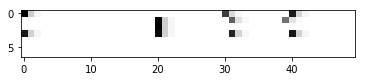

m (50, 7, 1)


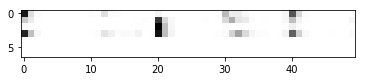

m (50, 7, 1)


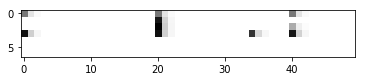

m (50, 7, 1)


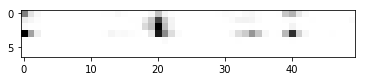

In [45]:
i = 240
j = 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [46]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [47]:
x.shape

(900, 160, 7, 1)

m (30, 7)


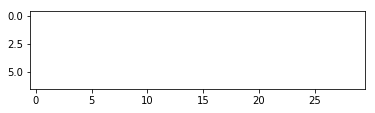

In [48]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 7)


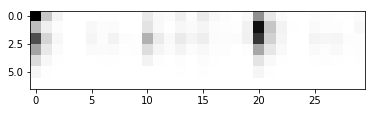

In [49]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [50]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [51]:
generator_input = Input((latent_dim,))
generator_layers_ = utils.composition(decoders, generator_input)
generator = Model(generator_input, generator_layers_)

In [52]:
decoder = generator

## Save models to disk
(requires h5py)

In [53]:
# models_io.save_model(vae, dn + prefix + '_vae')
# models_io.save_model(encoder, dn + prefix + '_encoder')
# models_io.save_model(generators, dn + prefix + '_generator')

## Style transfer

In [54]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 20)

original
m (160, 7, 1)


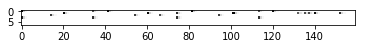

(21, 160, 7, 1) [ 0.0138014   0.03417258 -0.01636703  0.01480054 -0.01751276]
identity
m (160, 7, 1)


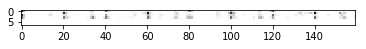

mutations
m (160, 7, 1)


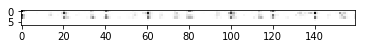

m (160, 7, 1)


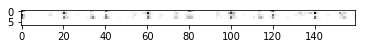

m (160, 7, 1)


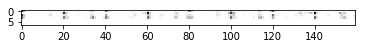

m (160, 7, 1)


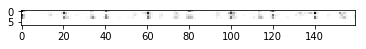

In [55]:
i = 100
amt = 0.3
print('original')
plot.single(x_train[i])
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = decoder.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
print('identity')
plot.single(generated[0]) 
print('mutations')
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

In [56]:
mido.MidiFile()

<midi file None type 1, 0 tracks, 0 messages>

In [57]:
# utils.clear_dir(config.export_dir)
for i, sample in enumerate(generated):
    s = midi.MultiTrack.from_array(sample)
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'generated-' + str(i))

 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.5302083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.5302083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.83020833333333

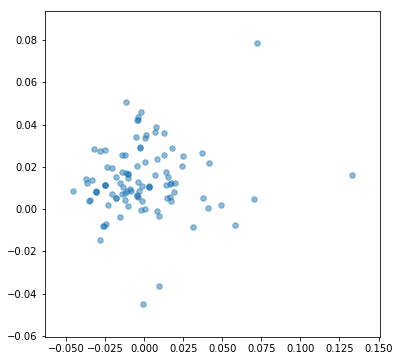

In [58]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

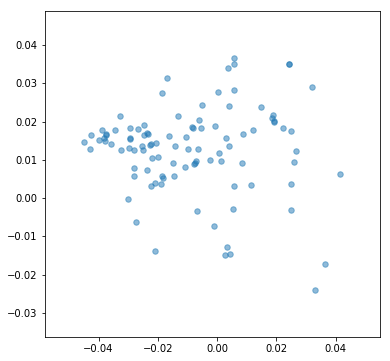

In [59]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [60]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [61]:
# x_decoded[0].reshape(150,3)

In [62]:
x_train.shape

(900, 160, 7, 1)

(20,) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]


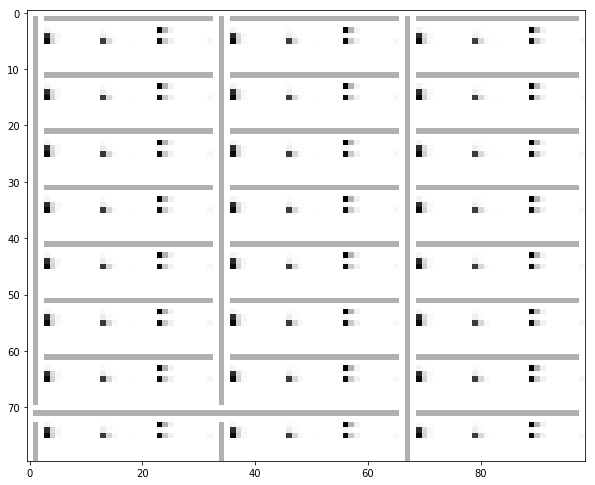

In [63]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(20,) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]


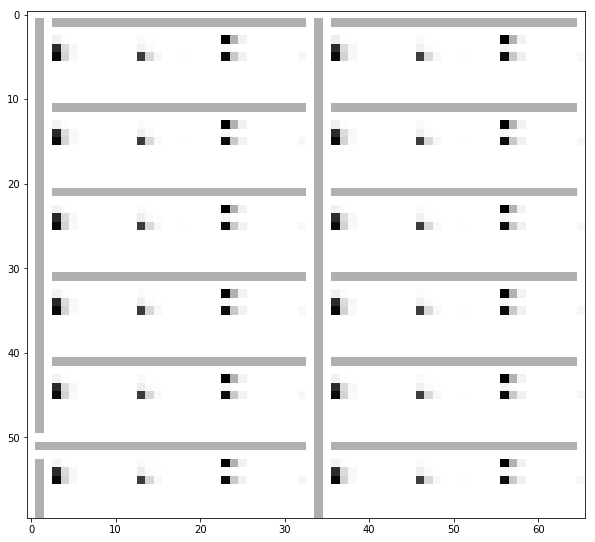

In [64]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [65]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

 [INFO] : 
 |  len, max_t
 |  3.8052083333333324
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.530208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0


# Style transfer
rock ~ funk

In [66]:
[(a,b) for a,b in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM/01 8th Snare.mid ../datasets/drum_midi//50´s Drummer MIDI Files/03 Traditional Pop/01 Fly High 115BPM/01 8th Hat.mid ../datasets/drum_midi//50´s Drummer MIDI Files/02 Blues/06 Vidar Vega 70BPM/01 8th Hat.mid
m (80, 7, 1)


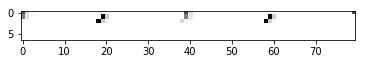

m (80, 7, 1)


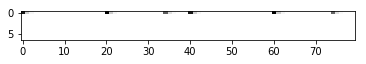

m (80, 7, 1)


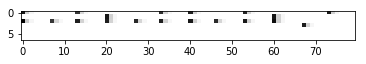

In [67]:
i,j,k = 21, 140, 105 # 210, 79
m = 80
sample_size = 10
print(labels[i], labels[j], labels[k])
plot.single(x_train[i,:m])
plot.single(x_train[j,:m])
plot.single(x_train[k,:m])

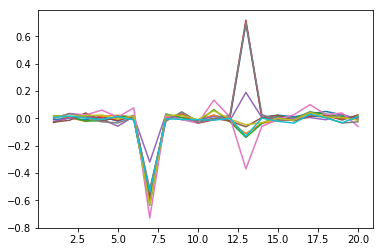

In [68]:
latent_vectors = encoder.predict(x_train[:250])
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

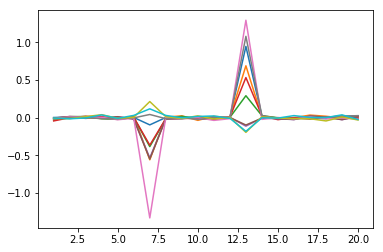

In [69]:
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + j])
# plt.ylim((-1,1))

In [70]:
a = x_train[i:i+sample_size]
b = x_train[j:j+sample_size]
c = x_train[k:k+sample_size]

In [71]:
t = models.extract_transformation(encoder, a, b)
t

array([-0.01058505, -0.00628328,  0.00042506,  0.001909  , -0.00380674,
       -0.0125548 ,  0.22308487, -0.00891936, -0.01447007,  0.01846032,
       -0.03297007,  0.00576909,  0.28137103,  0.02081198, -0.00775212,
       -0.00089853, -0.029233  , -0.01920506,  0.001358  ,  0.00784397],
      dtype=float32)

m (80, 7, 1)


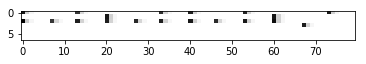

m (80, 7, 1)


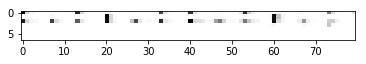

In [72]:
c_ = models.transfer_style(encoder, generator, a, b, c)
plot.single(c[0,:m])
plot.single(c_[0,:m])

In [73]:
d = {'original':c, 'generated':c_, 'a':a, 'b':b}
for name,v in d.items():
    mid = midi.decode.track(context, v[0], name=name)
    mid.tracks[0].name = name
    io.export_midifile(mid, config.export_dir + 'style_transfer-' + name)

 [INFO] : 
 |  len, max_t
 |  3.8552083333333336
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8552083333333336
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8802083333333335
 |  4.0


In [74]:
from sklearn.decomposition import PCA
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [75]:
pca = PCA(n_components=3)

In [76]:
pca_result = pca.fit_transform(latent_vectors)
pca_result.shape

(250, 3)

In [77]:
[round(v,3) for v in pca.explained_variance_ratio_], round(sum(pca.explained_variance_ratio_[:2]),2)

([0.569, 0.424, 0.002], 0.99)

In [78]:
pca.components_

array([[-7.8384532e-03, -8.8005252e-03,  3.4024320e-03, -6.9711353e-03,
         4.7953278e-03, -7.0966519e-03,  9.9548590e-01, -5.0715730e-03,
        -1.0353808e-02,  3.5679205e-03, -6.0203779e-03,  5.0756233e-03,
        -8.8559933e-02,  1.7163265e-02, -1.1727954e-02, -3.4145403e-03,
        -6.9879848e-03, -3.2747346e-03,  7.6675615e-03,  1.1090924e-02],
       [ 8.2621761e-03, -3.2954393e-03,  5.8844127e-03, -6.4759952e-04,
         5.6568617e-03,  3.4114223e-03, -8.8302031e-02,  4.2357221e-03,
         4.0968377e-03,  8.6291246e-03, -8.3176320e-04, -6.4603821e-03,
        -9.9584669e-01, -3.8465406e-03,  6.9310074e-03,  2.0598988e-03,
        -6.5266370e-04, -6.2495652e-03,  7.7932456e-04, -8.6915484e-03],
       [ 2.9187462e-01, -1.4327057e-02, -3.8521737e-01,  2.8194515e-02,
         4.4187605e-02,  2.1431455e-01,  1.7927364e-02,  1.5606178e-01,
         1.0438307e-02, -6.4422816e-02,  5.7936430e-01,  9.8375306e-02,
        -1.1654042e-04, -3.5547364e-01,  1.3818456e-01,  2.483

In [79]:
pca.singular_values_

array([14.143962 , 12.211849 ,  0.7398393], dtype=float32)

2 best dims


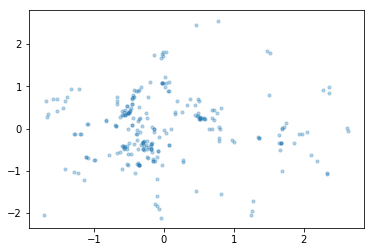

In [80]:
print('2 best dims')
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.3, s=10) # c=labels
# plt.ylim((-1,1))

2 best dims, 3 classes


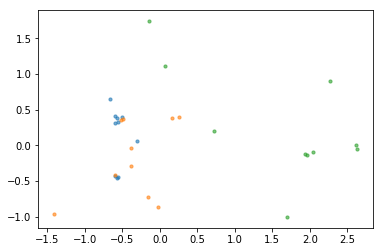

In [81]:
print('2 best dims, 3 classes')
for i_ in [i,j,k]:
    plt.scatter(pca_result[i_:i_+sample_size,0], pca_result[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))

In [82]:
# import ggplot
# chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
#         + geom_point(size=75,alpha=0.8) \
#         + ggtitle("First and Second Principal Components colored by digit")
# chart

In [83]:
from sklearn.manifold import TSNE

In [84]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)

In [85]:
# TODO shuffle data?
tsne_results = tsne.fit_transform(latent_vectors)
tsne_results.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.005s...
[t-SNE] Computed neighbors for 250 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.277761
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.860504
[t-SNE] Error after 500 iterations: 0.178955


(250, 2)

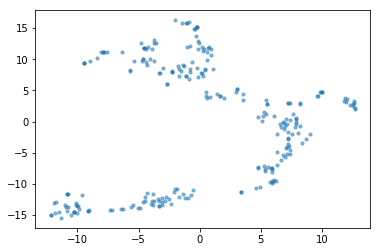

In [86]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5, s=10)

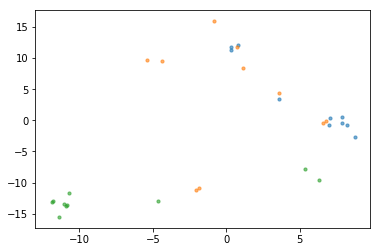

In [87]:
for i_ in [i,j,k]:
    plt.scatter(tsne_results[i_:i_+sample_size,0], tsne_results[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))